In [2]:
import pandas as pd

# Missing data

In this notebook we want to investigate missing data and methods to mitigate it.

In [3]:
df = pd.read_pickle('../data/data_discretised_200.pkl') # faster

In [4]:
df

user  year  month  day  hour  30min_interval           timestamp  \
0           0.0  2013     10   31    12             1.0 2013-10-31 12:16:30   
1           0.0  2013     10   31    12             2.0 2013-10-31 12:30:44   
2           0.0  2013     10   31    13             1.0 2013-10-31 13:01:29   
3           0.0  2013     10   31    13             2.0 2013-10-31 13:30:59   
4           0.0  2013     10   31    14             1.0 2013-10-31 14:00:52   
...         ...   ...    ...  ...   ...             ...                 ...   
12827787  851.0  2015      8    7    20             1.0 2015-08-07 20:03:13   
12827788  851.0  2015      8    7    20             2.0 2015-08-07 20:33:14   
12827789  851.0  2015      8    7    21             1.0 2015-08-07 21:03:15   
12827790  851.0  2015      8    7    21             2.0 2015-08-07 21:33:15   
12827791  851.0  2015      8    7    22             1.0 2015-08-07 22:02:58   

          stoplocation   latitude  longitude  lat_bin  lon_bin  
0                   98  55.783644  12.518416      143      142  
1                   28  55.781990  12.521609      142      143  
2                   28  55.781990  12.521609      142      143  
3                   28  55.781990  12.521609      142      143  
4                   28  55.781990  12.521609      142      143  
...                ...        ...        ...      ...      ...  
12827787            26  56.123877   9.849060      200        0  
12827788            26  56.123877   9.849060      200        0  
12827789            26  56.123877   9.849060      200        0  
12827790            26  56.123877   9.849060      200        0  
12827791            26  56.123877   9.849060      200        0  

[12827792 rows x 12 columns]

In [5]:
# Sort the data
df.sort_values(['user', 'year', 'month', 'day', 'hour', '30min_interval'], inplace=True)

In [6]:
# create a date column
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [7]:
# Convert the date column to datetime type and extract just the date
df['date'] = pd.to_datetime(df['date']).dt.date

In [8]:
# show first and last day
print(df['date'].min())
print(df['date'].max())

2013-09-30
2015-09-30


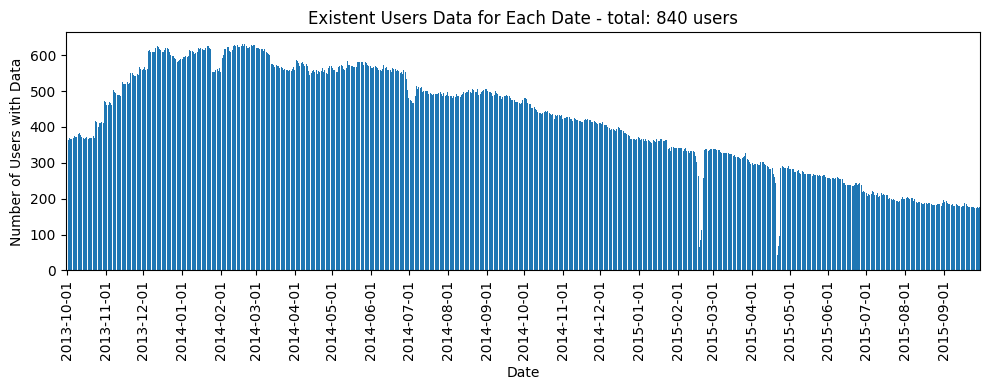

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Group by 'date' and 'user', count the records for each group
grouped = df.groupby(['date', 'user']).size().reset_index(name='count')

# Count unique users per date
user_count_per_date = grouped.groupby('date')['user'].nunique().reset_index(name='unique_users')

# Plotting
plt.figure(figsize=(10, 4))
plt.bar(user_count_per_date['date'], user_count_per_date['unique_users'])
plt.xlabel('Date')
plt.ylabel('Number of Users with Data')
plt.title('Existent Users Data for Each Date - total: ' + str(len(df.user.unique())) + ' users')

# Define tick locations to be every first of the month
ticks_loc = pd.date_range(start=user_count_per_date['date'].min(), end=user_count_per_date['date'].max(), freq='MS')
plt.xlim([user_count_per_date['date'].min(), user_count_per_date['date'].max()])
plt.xticks(ticks_loc, ticks_loc.strftime('%Y-%m-%d'), rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()

# save figure with 300 dpi
plt.savefig('../figures/number_of_users_per_date.png', dpi=300)

plt.show()


This plot shows, how many users where existing in the data set in each month. We can see, that the number of users is first increasing and later steadily decreasing over time.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'date' and 'user', then count the records for each group
grouped = df.groupby(['date', 'user']).size().reset_index(name='count')

# Create a pivot table to get active days for each user
pivot_table = pd.pivot_table(grouped, values='count', index=['user'], columns=['date'], fill_value=0)

# Convert the count values to binary (active or not)
binary_pivot_table = pivot_table.applymap(lambda x: 1 if x > 0 else 0)

# Create the heatmap
plt.figure(figsize=(80, 80)) 
sns.heatmap(binary_pivot_table, cmap="Blues", cbar=False, yticklabels=True, xticklabels=True)

plt.title('User Activity Heatmap')
plt.xlabel('Date')
plt.ylabel('User')
plt.xticks(rotation=90)
plt.tight_layout()

# Save figure with 300 dpi
plt.savefig('../figures/user_activity_heatmap.png', dpi=300)

plt.show()


/tmp/ipykernel_1041511/4240996283.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_pivot_table = pivot_table.applymap(lambda x: 1 if x > 0 else 0)


In [11]:
grouped

date   user  count
0       2013-09-30    2.0      4
1       2013-09-30    4.0      4
2       2013-09-30    9.0      4
3       2013-09-30   10.0      4
4       2013-09-30   11.0      4
...            ...    ...    ...
305911  2015-09-30  827.0     44
305912  2015-09-30  828.0     44
305913  2015-09-30  842.0     44
305914  2015-09-30  843.0     44
305915  2015-09-30  850.0     44

[305916 rows x 3 columns]

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Group by 'date', 'user', 'lat_bin', 'lon_bin' and then count the records for each group
grouped = df.groupby(['date', 'user', 'lat_bin', 'lon_bin']).size().reset_index(name='count')

# Determine whether lat_bin or lon_bin is 0 or 200 for each user and date
special_bin_df = grouped[(grouped['lat_bin'].isin([0, 200])) | (grouped['lon_bin'].isin([0, 200]))] # !!OBS!! needs to be changed for differnt bin sizes
special_bin_df = special_bin_df.groupby(['date', 'user']).size().reset_index(name='special_count')

# Create pivot tables to get active and special days for each user
active_pivot = pd.pivot_table(grouped, values='count', index=['user'], columns=['date'], fill_value=0)
special_pivot = pd.pivot_table(special_bin_df, values='special_count', index=['user'], columns=['date'], fill_value=0)

# Convert the count values to binary (active or not)
binary_active_pivot = active_pivot.applymap(lambda x: 1 if x > 0 else 0)
binary_special_pivot = special_pivot.applymap(lambda x: 2 if x > 0 else 0)

# Merge the two binary pivot tables
merged_pivot = binary_active_pivot.add(binary_special_pivot, fill_value=0).astype(int)

# Create a new column 'total_activity' which is the sum of activity for each user
merged_pivot['total_activity'] = merged_pivot.sum(axis=1)

# Sort the DataFrame based on 'total_activity' column
# Note: Set 'ascending=False' to have users with higher activity at the top
merged_pivot = merged_pivot.sort_values(by='total_activity', ascending=False)

# Drop the 'total_activity' column as it's no longer needed
merged_pivot = merged_pivot.drop(columns=['total_activity'])

# Create custom color palette, including white for the empty cells
cmap = sns.color_palette("crest", 3)
cmap[0] = (1, 1, 1)  # white color for zero

# Create the heatmap
plt.figure(figsize=(80, 80))
sns.heatmap(merged_pivot, cmap=cmap, cbar=False, yticklabels=True, xticklabels=True)

plt.title('User Activity Heatmap')
plt.xlabel('Date')
plt.ylabel('User')
plt.xticks(rotation=90)
plt.tight_layout()

# Save figure with 300 dpi
plt.savefig('../figures/user_activity_heatmap_with_outside_info_sorted.png', dpi=300)

plt.show()


/tmp/ipykernel_1041511/3713241890.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_active_pivot = active_pivot.applymap(lambda x: 1 if x > 0 else 0)
/tmp/ipykernel_1041511/3713241890.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_special_pivot = special_pivot.applymap(lambda x: 2 if x > 0 else 0)


## Active users per hour and week

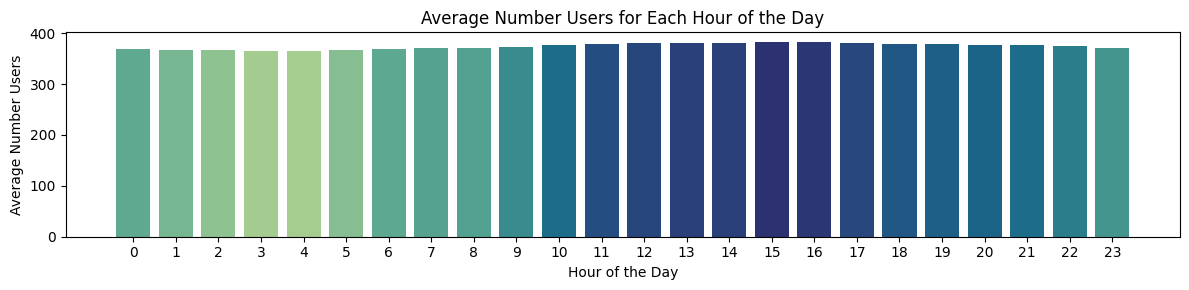

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns 


# Group by 'date', 'hour' and 'user', count the records for each group
grouped = df.groupby([df['date'], 'hour', 'user']).size().reset_index(name='count')

# Count unique users per hour for each date
user_count_per_hour_date = grouped.groupby(['date', 'hour'])['user'].nunique().reset_index(name='unique_users')

# Calculate the average number of unique users for each hour over all days
avg_user_count_per_hour = user_count_per_hour_date.groupby('hour')['unique_users'].mean().reset_index(name='avg_unique_users')

# Normalize the average user counts for color mapping
norm = plt.Normalize(avg_user_count_per_hour['avg_unique_users'].min(), avg_user_count_per_hour['avg_unique_users'].max())

# Create a colormap
cmap = plt.get_cmap('crest')  # Using 'crest' from Seaborn


# Plotting
plt.figure(figsize=(12, 3))

bar = plt.bar(avg_user_count_per_hour['hour'], avg_user_count_per_hour['avg_unique_users'], color=cmap(norm(avg_user_count_per_hour['avg_unique_users'].values)))

plt.xlabel('Hour of the Day')
plt.ylabel('Average Number Users')
plt.title('Average Number Users for Each Hour of the Day')
plt.xticks(np.arange(0, 24))
plt.tight_layout()

# Save figure with 300 dpi
plt.savefig('../figures/avg_number_of_users_per_hour_crest.png', dpi=300)

plt.show()


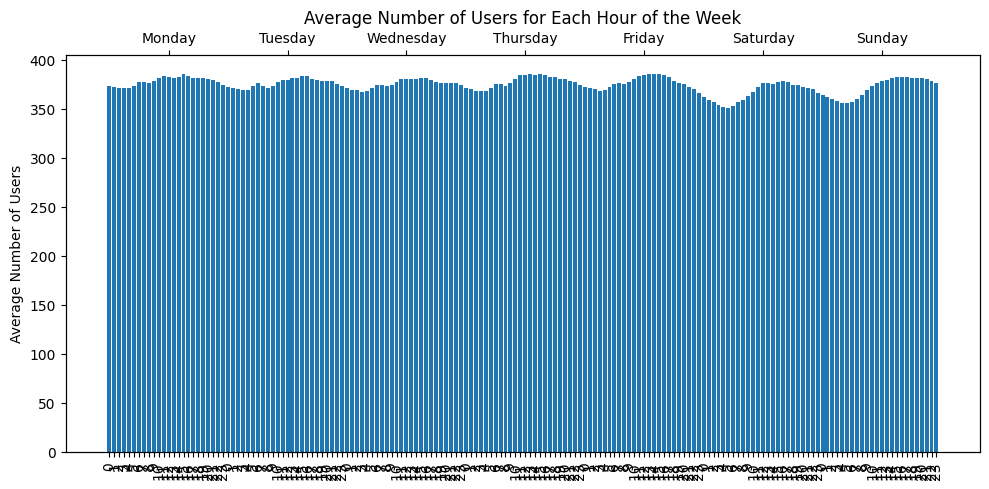

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from matplotlib.ticker import MaxNLocator


# Convert date column to datetime type and extract the weekday name
df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.day_name()

# Create a 'weekday_hour' column combining the day of the week and the hour
df['weekday_hour'] = df['weekday'] + '_' + df['hour'].astype(str)

# Group by 'date', 'weekday_hour' and 'user', then count the records for each group
grouped = df.groupby(['date', 'weekday_hour', 'user']).size().reset_index(name='count')

# Count unique users per hour for each date and weekday_hour
user_count_per_weekday_hour = grouped.groupby(['date', 'weekday_hour'])['user'].nunique().reset_index(name='unique_users')

# Calculate the average number of unique users for each weekday_hour over all days
avg_user_count_per_weekday_hour = user_count_per_weekday_hour.groupby('weekday_hour')['unique_users'].mean().reset_index(name='avg_unique_users')

# Sort values by weekday and hour
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_user_count_per_weekday_hour['weekday'] = avg_user_count_per_weekday_hour['weekday_hour'].apply(lambda x: x.split('_')[0])
avg_user_count_per_weekday_hour['hour'] = avg_user_count_per_weekday_hour['weekday_hour'].apply(lambda x: int(x.split('_')[1]))
avg_user_count_per_weekday_hour['weekday'] = pd.Categorical(avg_user_count_per_weekday_hour['weekday'], categories=ordered_days, ordered=True)
avg_user_count_per_weekday_hour = avg_user_count_per_weekday_hour.sort_values(by=['weekday', 'hour'])




/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


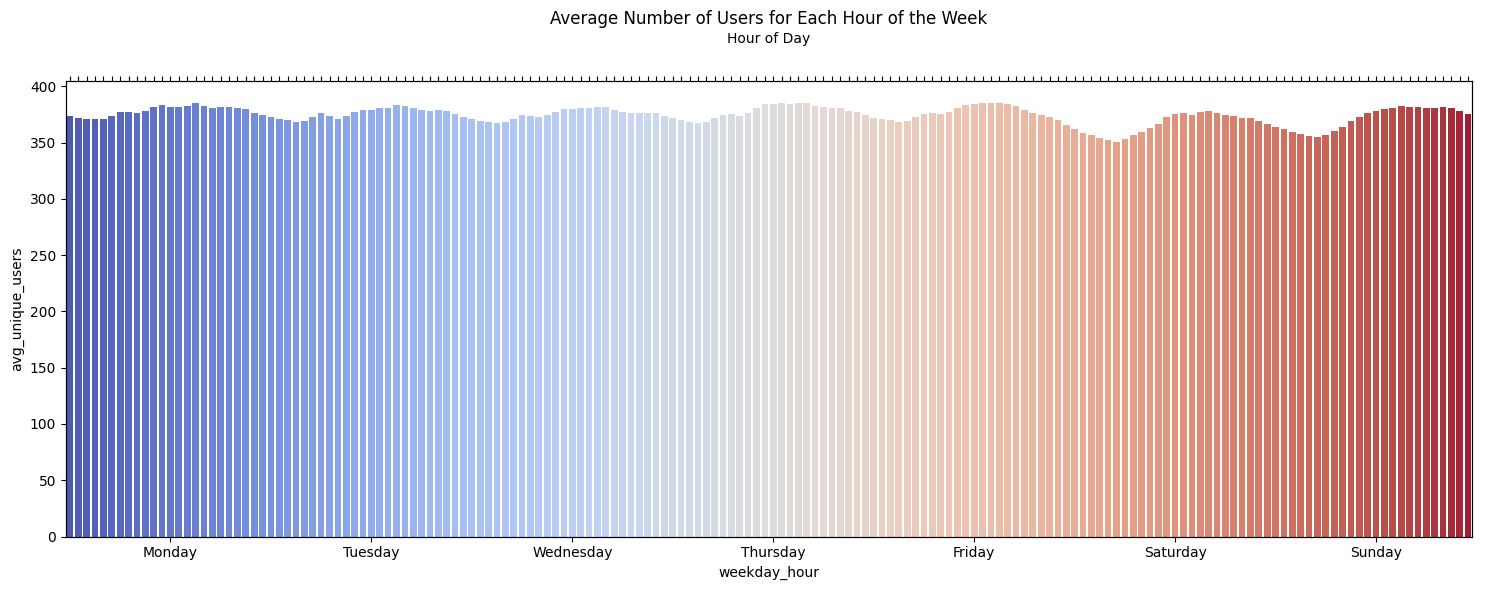

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already defined and includes 'date' and 'hour' columns

# Your existing data preparation code here...

# Plotting with Seaborn
plt.figure(figsize=(15, 6))

# Create a bar plot
ax = sns.barplot(x='weekday_hour', y='avg_unique_users', data=avg_user_count_per_weekday_hour, palette='coolwarm')

# Custom handling for x-axis labels
# Calculate the positions for the day labels to be in the middle of their respective groups
unique_days = avg_user_count_per_weekday_hour['weekday'].unique()
day_positions = []
for day in unique_days:
    positions = [i for i, label in enumerate(new_labels) if label[0] == day]
    if positions:
        day_middle = positions[len(positions) // 2]
        day_positions.append((day, day_middle))

# Set custom day labels
ax.set_xticks([pos for _, pos in day_positions])
ax.set_xticklabels([day for day, _ in day_positions])

# Add the hour labels (second level) below the first level using a secondary x-axis
hours = [label[1] for label in new_labels]  # Extracted earlier
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
# Set all original positions for the hours but make labels invisible
ax2.set_xticks(range(len(hours)))
ax2.set_xticklabels(hours, rotation=90)  # Making hour labels invisible here
# Creating dummy invisible bars for correct alignment - workaround
for pos in [pos for _, pos in day_positions]:
    ax2.text(pos, 0, '', ha='center', va='bottom')  # Placeholder texts for alignment

ax2.set_xlabel('Hour of Day')
ax.xaxis.set_tick_params(rotation=0)  

plt.ylabel('Average Number of Users')
plt.title('Average Number of Users for Each Hour of the Week')
plt.tight_layout()
plt.savefig('../figures/avg_number_of_users_per_weekday_hour_seaborn.png', dpi=300)
plt.show()


Create a function to generate all possible combinations of year, month, day, hour, and 30-minute intervals.

In [15]:
from itertools import product

def generate_time_combinations(years, months, days, hours, intervals):
    return list(product(years, months, days, hours, intervals))

Loop through each user and identify the missing entries.

In [16]:
unique_users = df['user'].unique()
unique_years = df['year'].unique()
unique_months = df['month'].unique()
unique_days = range(1, 32)  # Assuming all months and up to 31 days
unique_hours = range(24)  # 0 to 23 for hours
unique_intervals = df['30min_interval'].unique()  

missing_entries = []

for user in unique_users:
    user_data = df[df['user'] == user]
    
    # Generate all possible combinations for this user
    all_time_combinations = generate_time_combinations(unique_years, unique_months, unique_days, unique_hours, unique_intervals)
    
    for time_combination in all_time_combinations:
        year, month, day, hour, interval = time_combination
        subset = user_data[
            (user_data['year'] == year) & 
            (user_data['month'] == month) & 
            (user_data['day'] == day) & 
            (user_data['hour'] == hour) & 
            (user_data['30min_interval'] == interval)
        ]
        
        # If subset is empty, then this combination is missing for this user
        if subset.empty:
            missing_entry = {
                'user': user,
                'year': year,
                'month': month,
                'day': day,
                'hour': hour,
                '30min_interval': interval,
                # Add other columns as NaN or default values
                'stoplocation': None,
                'latitude': None,
                'longitude': None,
                'lat_bin': None,
                'lon_bin': None,
            }
            missing_entries.append(missing_entry)

missing_data = pd.DataFrame(missing_entries)


In [ ]:
missing_data = pd.DataFrame(missing_entries)


In [ ]:
missing_data

user  year  month  day  hour  30min_interval stoplocation latitude  \
0           0.0  2013     10    1     0             1.0         None     None   
1           0.0  2013     10    1     0             2.0         None     None   
2           0.0  2013     10    1     1             1.0         None     None   
3           0.0  2013     10    1     1             2.0         None     None   
4           0.0  2013     10    1     2             1.0         None     None   
...         ...   ...    ...  ...   ...             ...          ...      ...   
13904562  386.0  2013      5   13    13             2.0         None     None   
13904563  386.0  2013      5   13    14             1.0         None     None   
13904564  386.0  2013      5   13    14             2.0         None     None   
13904565  386.0  2013      5   13    15             1.0         None     None   
13904566  386.0  2013      5   13    15             2.0         None     None   

         longitude lat_bin lon_bin  
0             None    None    None  
1             None    None    None  
2             None    None    None  
3             None    None    None  
4             None    None    None  
...            ...     ...     ...  
13904562      None    None    None  
13904563      None    None    None  
13904564      None    None    None  
13904565      None    None    None  
13904566      None    None    None  

[13904567 rows x 11 columns]

In [ ]:
# save to pickle
missing_data.to_pickle('../data/missing_data.pkl')

Plots

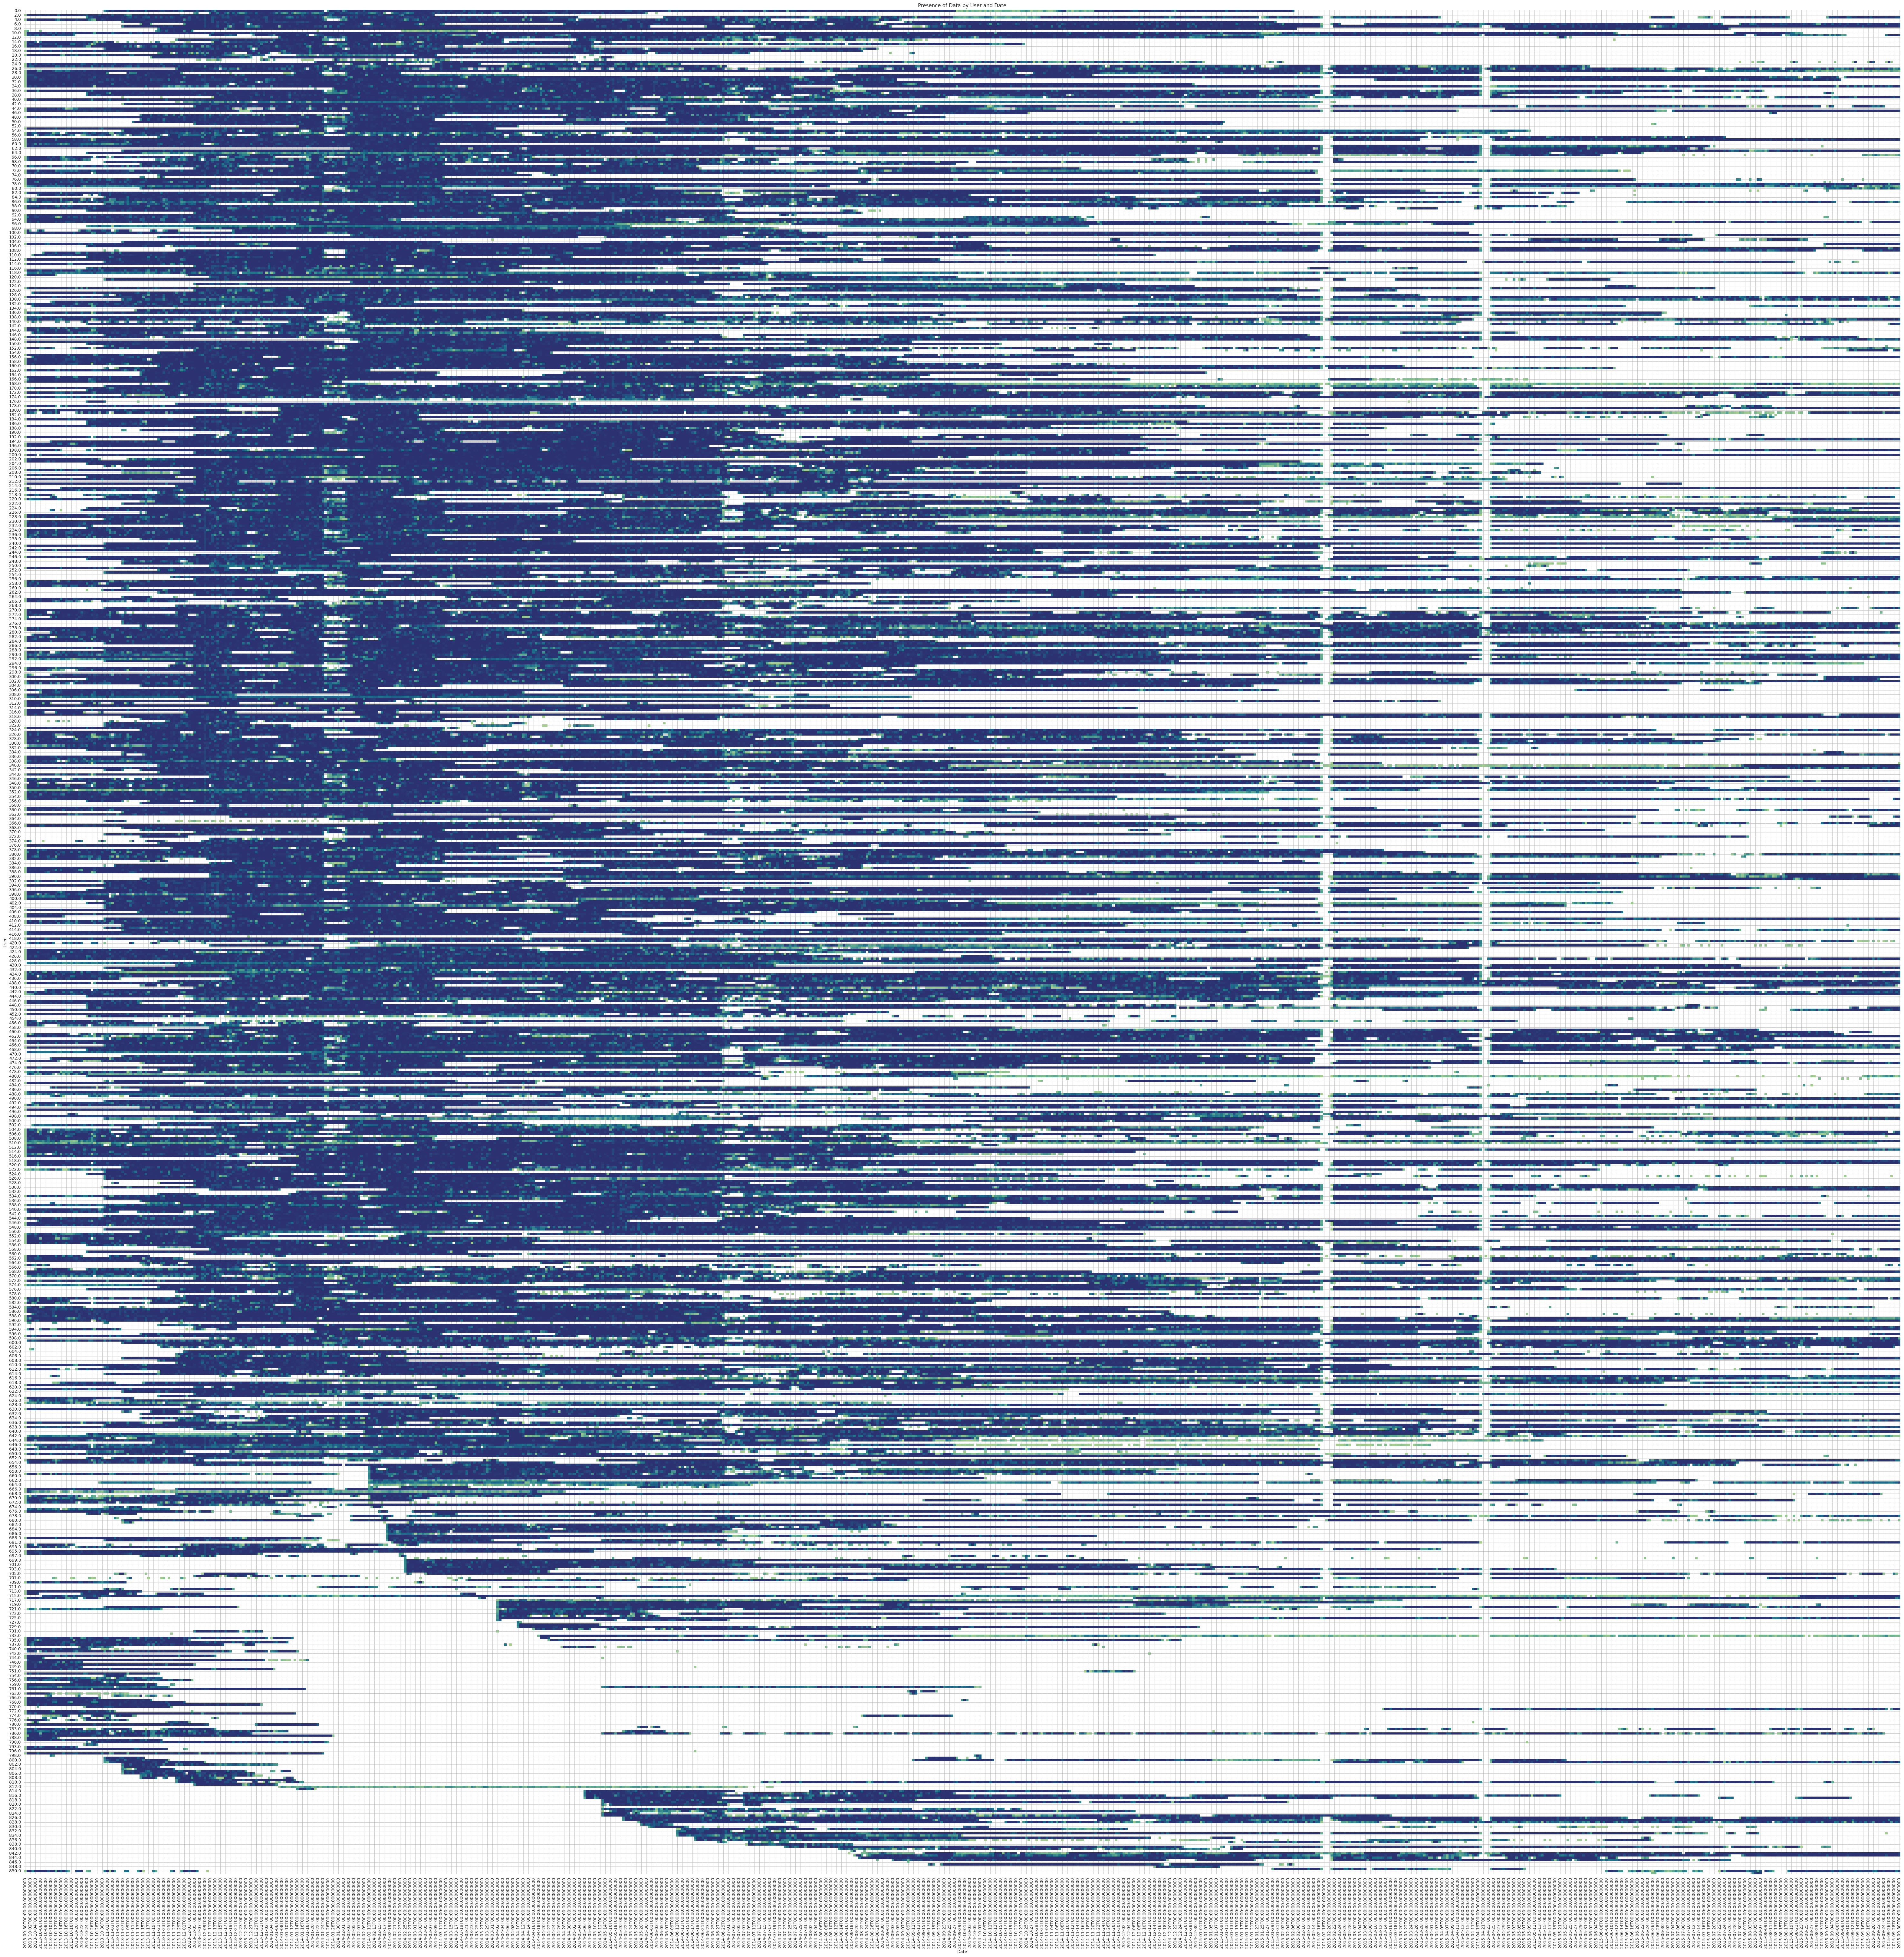

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your data
# df = pd.read_csv('your_dataset.csv')

# Make sure to sort the data first
df.sort_values(['user', 'year', 'month', 'day'], inplace=True)

# Create a new column that combines year, month, and day into a single date
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Create a pivot table, placing 'user' on y-axis and the 'date' on the x-axis
pivot_df = df.pivot_table(values='stoplocation',  # Use any column that always has data
                          index='user', 
                          columns='date', 
                          aggfunc='count')

# Draw a heatmap
plt.figure(figsize=(80, 80))
sns.heatmap(pivot_df, annot=False, cmap='crest', cbar=False)
plt.title('Presence of Data by User and Date')
plt.xlabel('Date')
plt.ylabel('User')
plt.savefig('../figures/missing_data_heatmap.png', dpi=300)
plt.show()


